<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Watts-Strogatz and the Small-World Effect</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt 
import networkx as nx

from tqdm import tqdm

import watermark

%load_ext watermark
%matplotlib inline

Watermark the notebook with current versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 09938236a5375b6d0e9cb4a1618d9e4ed73cf99d

watermark : 2.1.0
json      : 2.0.9
networkx  : 2.5
pandas    : 1.1.3
matplotlib: 3.3.2
numpy     : 1.19.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Graph Models

### Regular Ring

We now proceed to defining a regular ring graph where each node is connected with K/2 neighbors on the left and K/2 neighbours on the right. This will be a stepping stone towards the full fledged Watts-Strogats model

In [4]:
def ring_graph(N, K):
    nodes = np.arange(N)
    edges = []
    
    K = K//2
    
    for i in range(N):
        for j in range(i+1, i+K+1):
            edges.append((i, j%N))
        
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

To generate a small regular ring we simply do

In [5]:
N = 100
K = 4
RG = ring_graph(N, K)

Naturally the degree distribution is pretty simple

In [6]:
Pk = pd.DataFrame(Counter(dict(RG.degree()).values()).items(), columns=['k', 'Pk']).sort_values('k')
Pk.Pk/=N

With all nodes having degree 4

In [7]:
Pk

,k,Pk
0,4,1.0


### Watts-Strogatz model

The first step towards defining a WS model is to implementing the rewiring procedure. This takes an existing graph and randomly rewires it's edges with probability $p$

In [8]:
def rewire(G, p):
    node_labels = list(G.nodes)
    nodes = dict(zip(node_labels, range(len(node_labels))))
    
    edges = G.edges()
        
    for node_i, node_j in edges:
        # Make sure we just rewire one end of the edge
        if nodes[node_j] > nodes[node_i]: 
            prob = np.random.random()

            if prob < p:
                new_node_j = node_labels[np.random.randint(len(node_labels))]
                G.add_edge(node_i, new_node_j)
                G.remove_edge(node_i, node_j)

So if we apply it to the previous graph, we significantly impact the degree distribution

In [9]:
RG = ring_graph(10000, 4)
rewire(RG, 0.3)

In [10]:
Pk = pd.DataFrame(Counter(dict(RG.degree()).values()).items(), columns=['k', 'Pk']).sort_values('k')
Pk.Pk/=10000

Which is now significantly broader while still peaked at 4

Text(0, 0.5, 'P(k)')

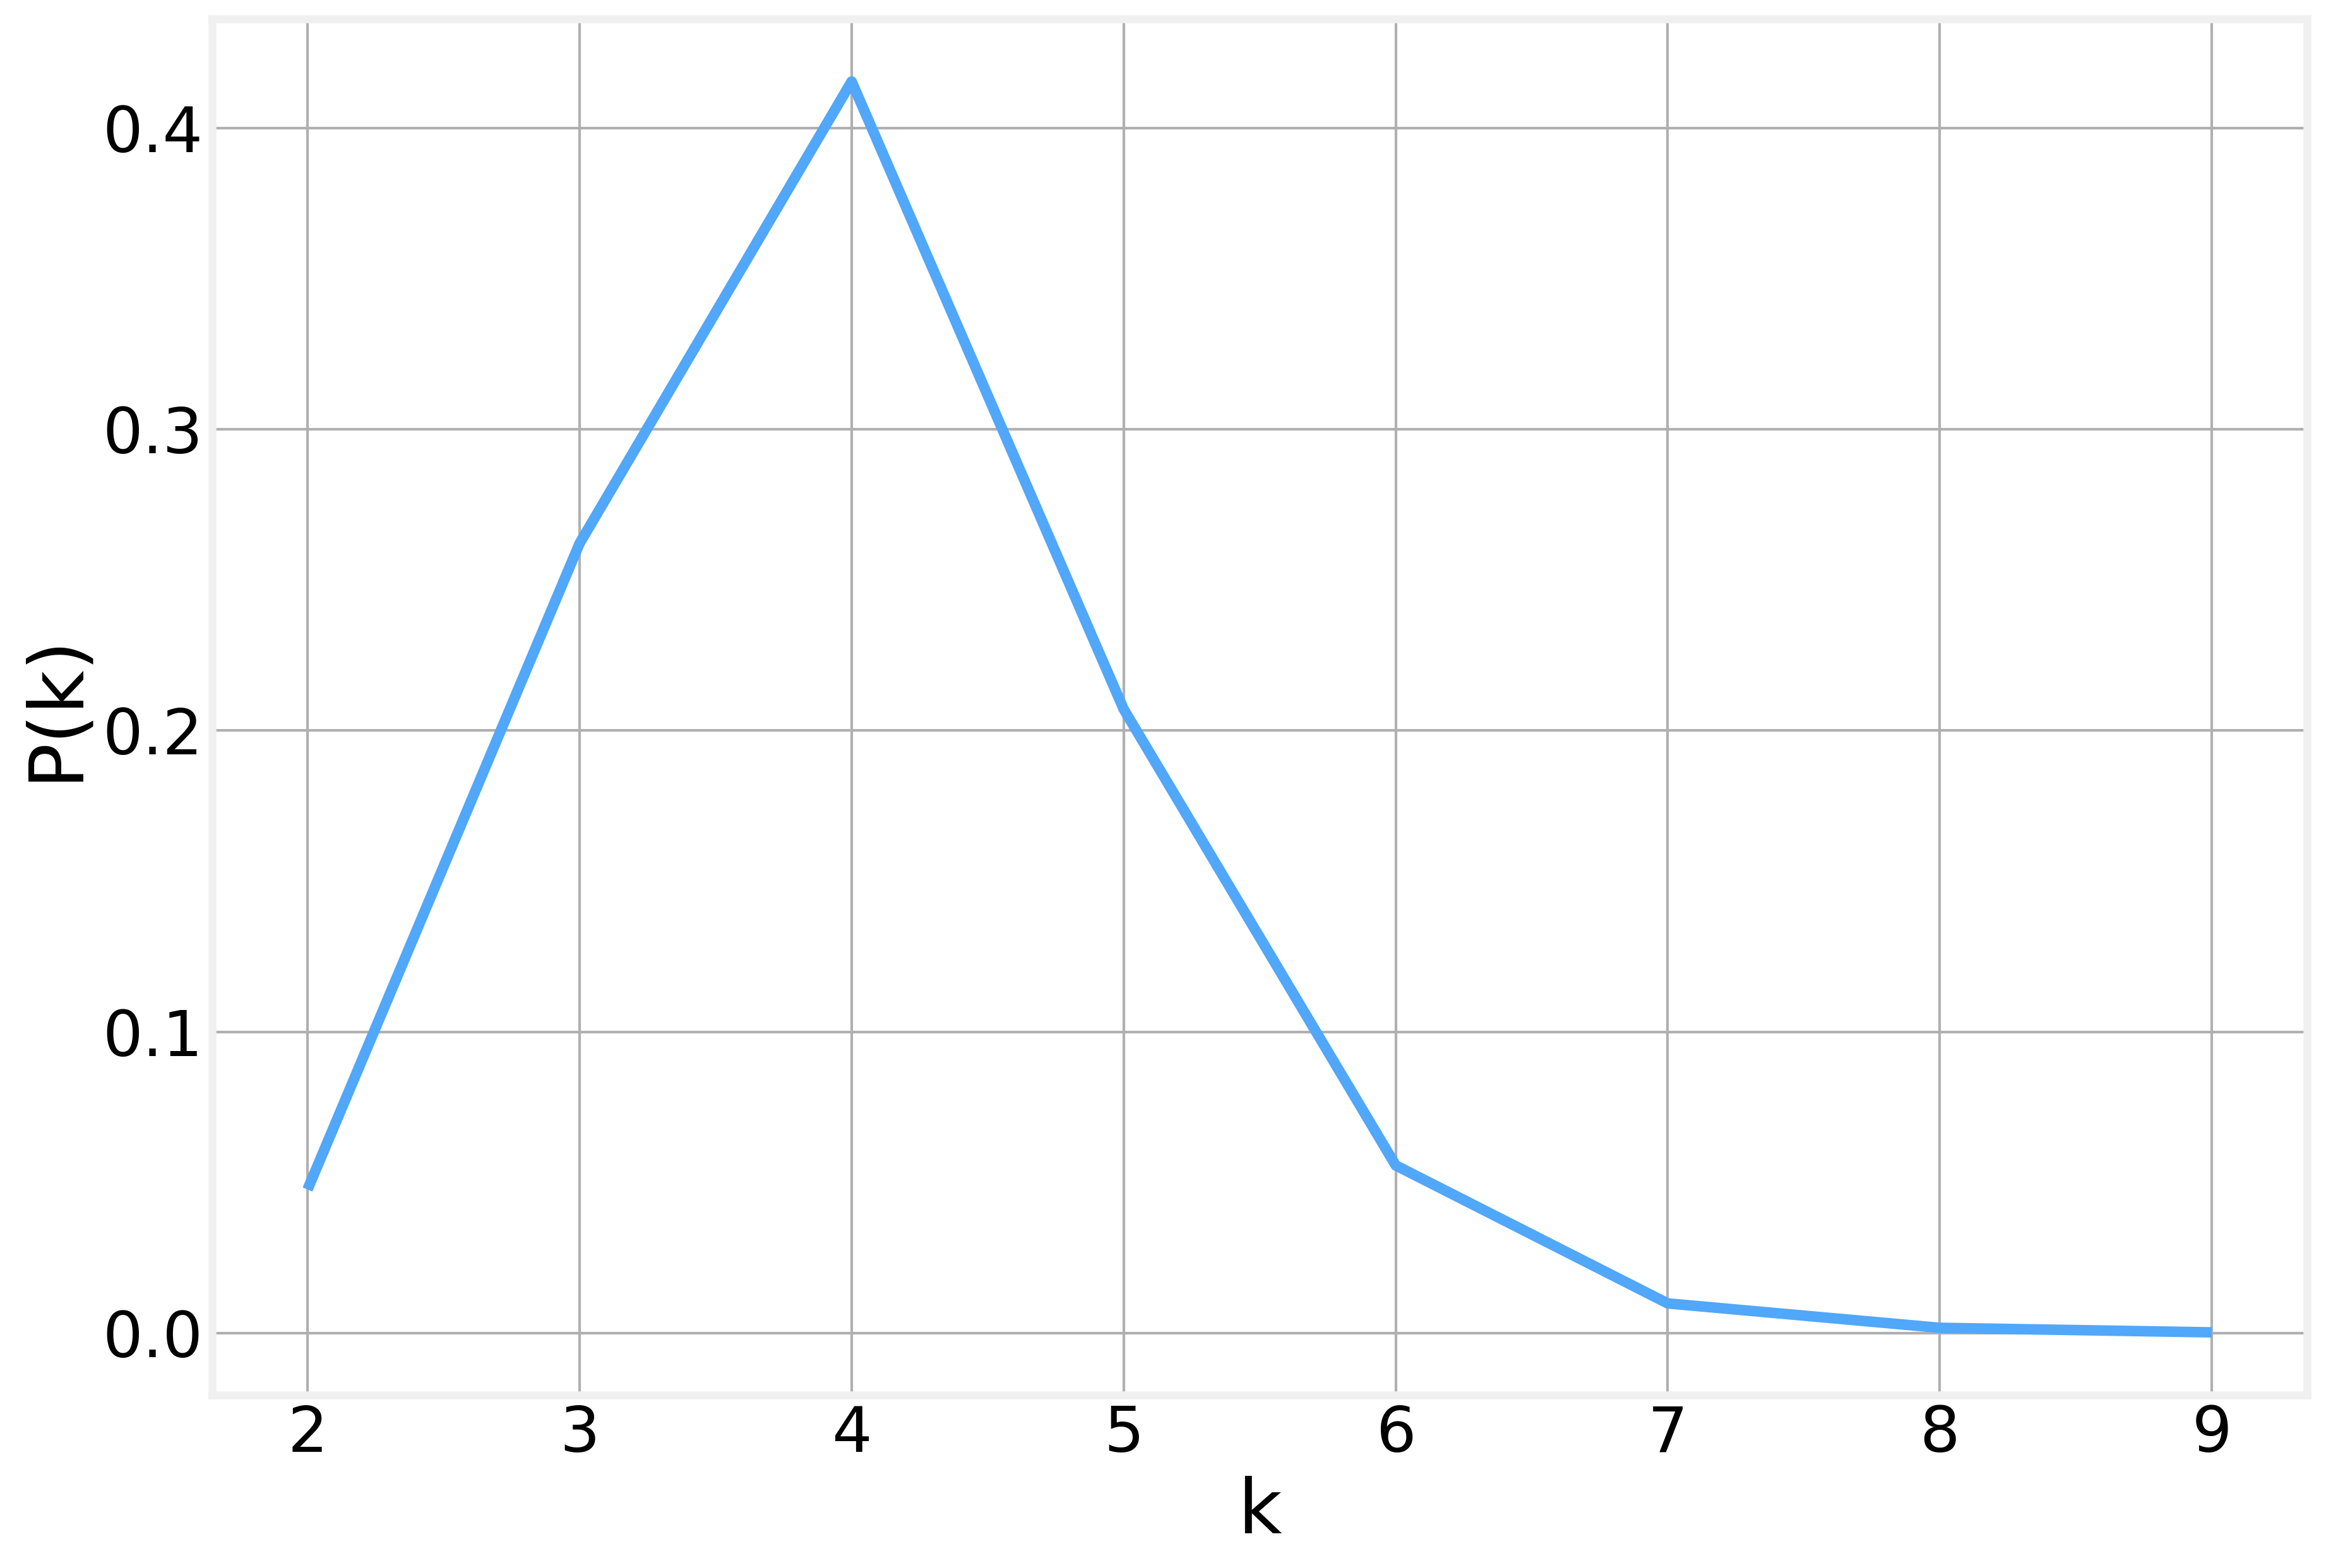

In [11]:
ax = Pk.plot(x='k', y='Pk', legend=None)
ax.set_xlabel('k')
ax.set_ylabel('P(k)')

The Watts-Strogatz model is then, simply

In [12]:
def watts_strogatz_graph(N, K, p):
    G = ring_graph(N, K)
    rewire(G, p)
    
    return G

# Small World Effect

We measure the clustering and average shortest path for various values of p

In [13]:
p = 1
values = []

for i in tqdm(range(1, 16), total=15):
    G = watts_strogatz_graph(1_000, 4, p)
    c = nx.algorithms.cluster.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    values.append([c, l, p])
    p /= 2.

100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


And plot them

In [14]:
WS_stats = pd.DataFrame(values, columns=['clustering', 'diameter', 'p'])
WS_stats = WS_stats.div(WS_stats.max())

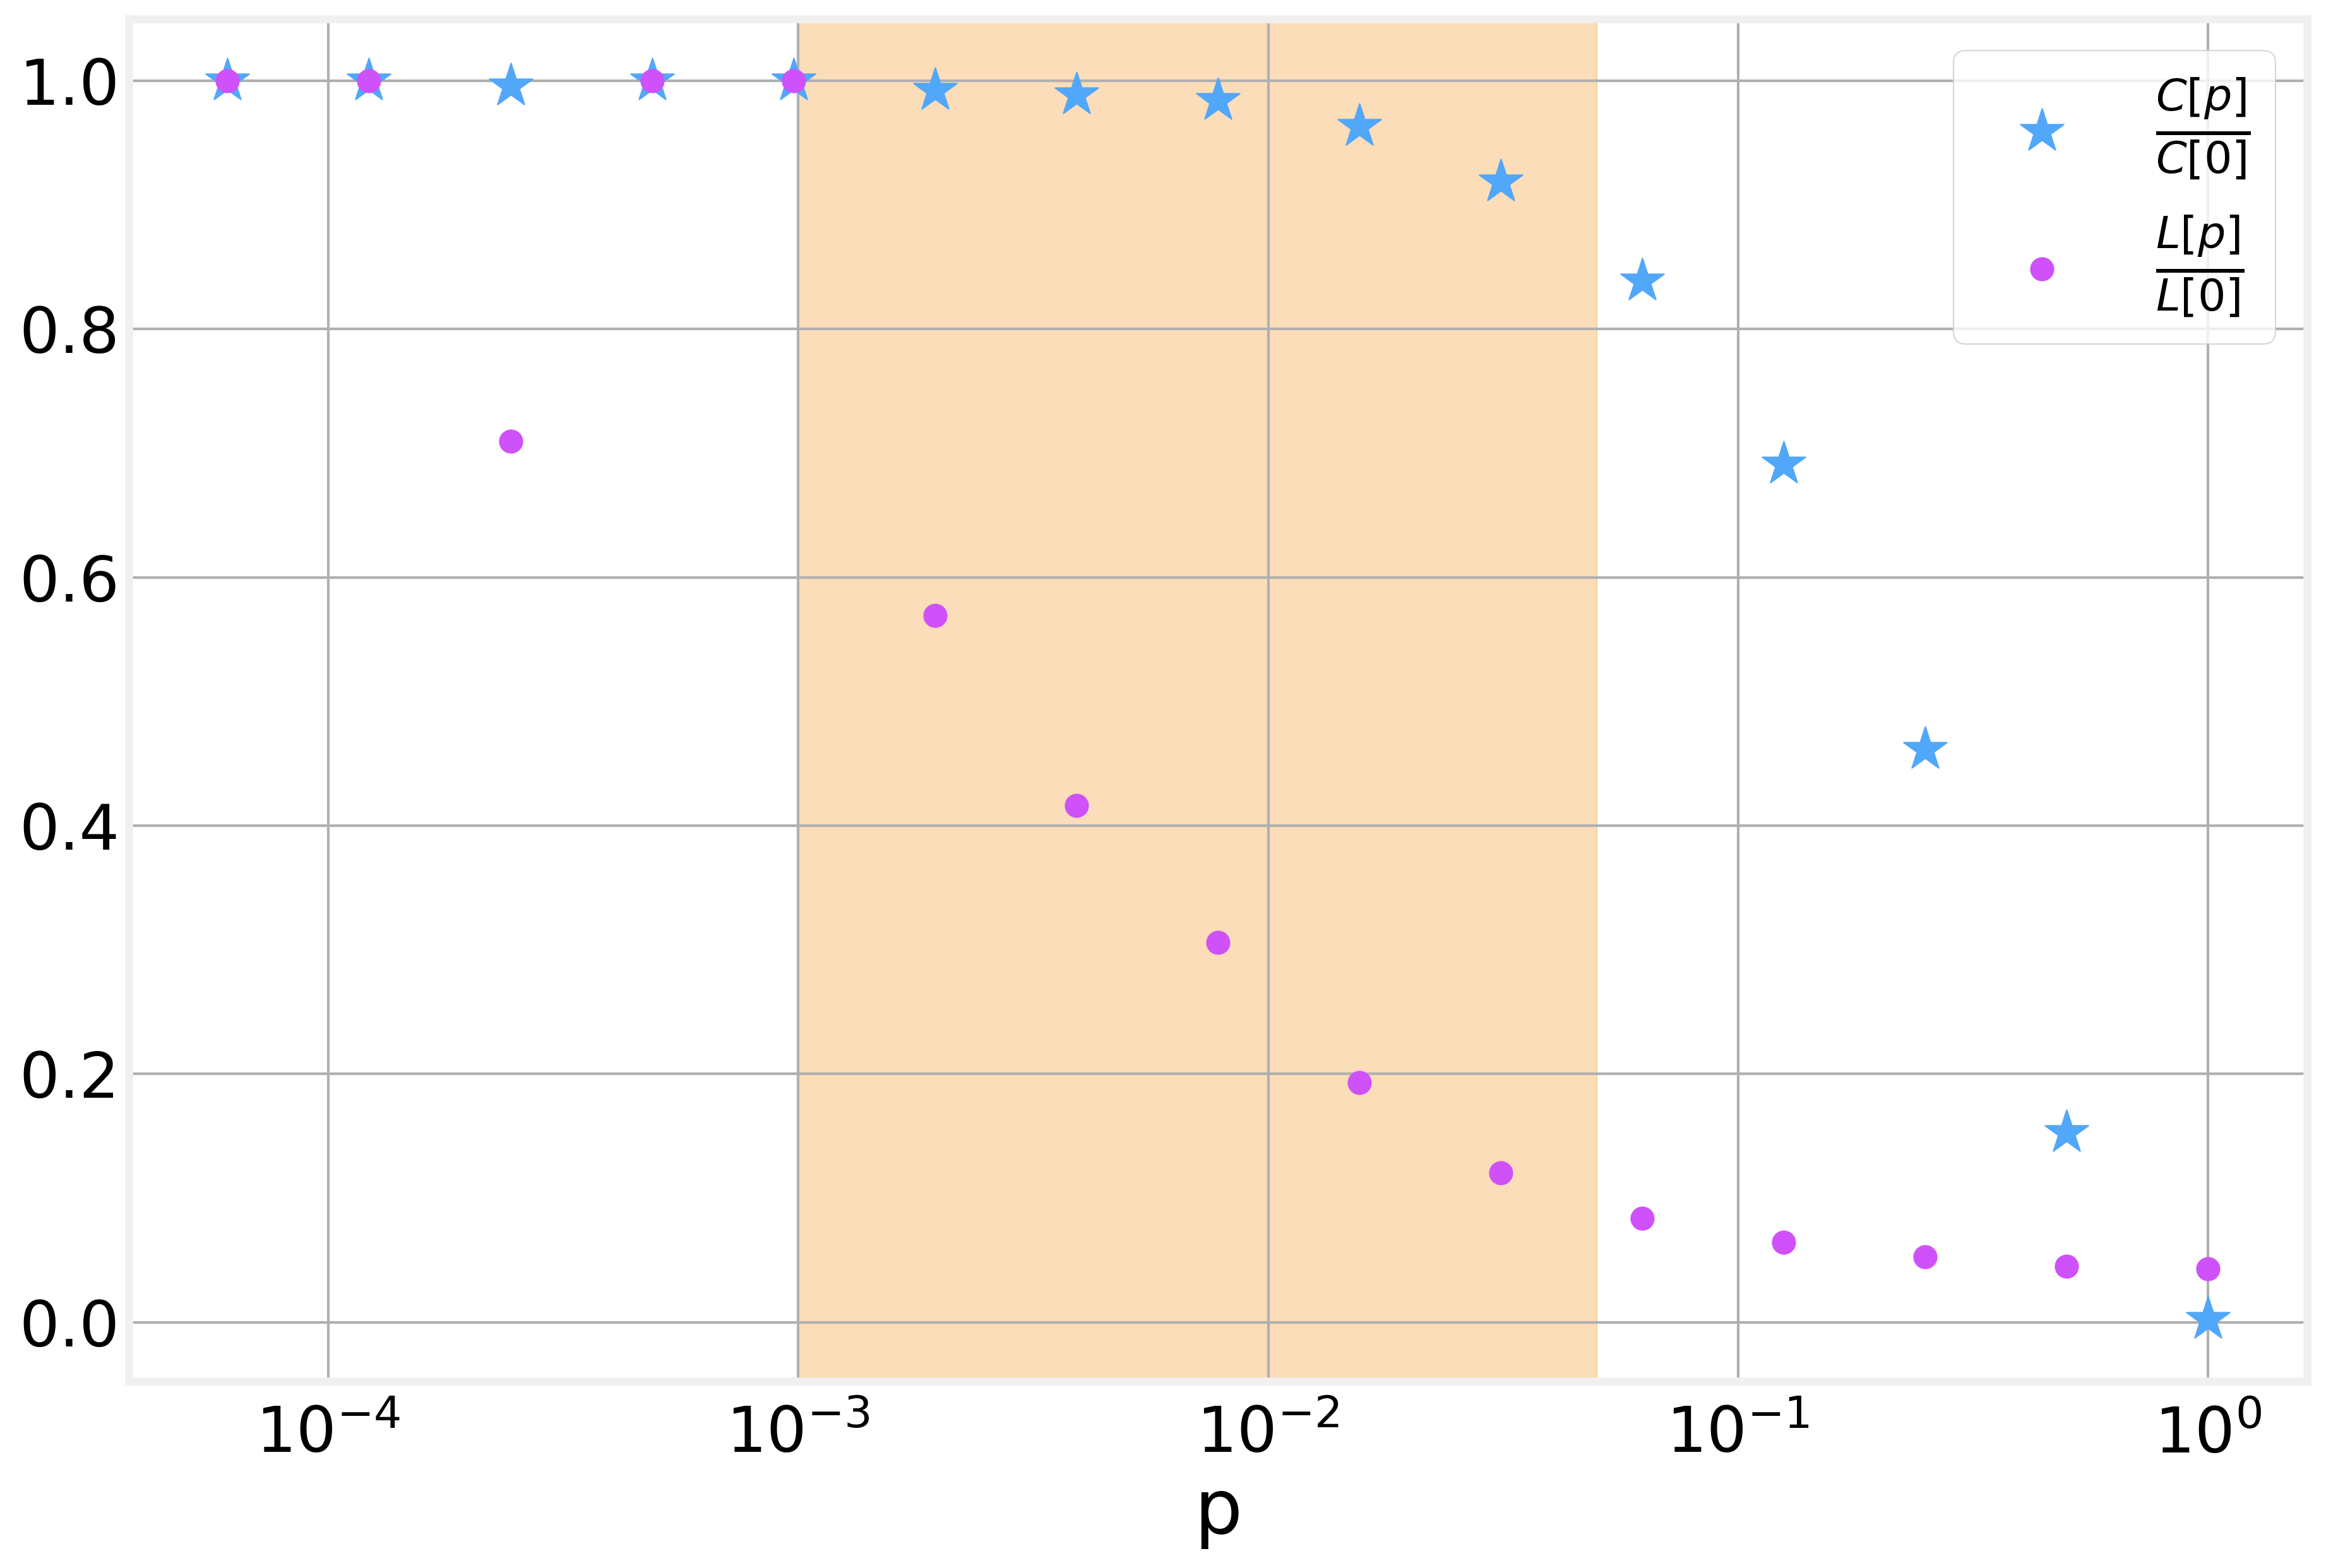

In [15]:
ax = WS_stats.plot.scatter(x='p', y='clustering', marker='*', 
                           label=r'$\frac{C[p]}{C[0]}$', 
                           color=colors[0], s=300)
WS_stats.plot.scatter(x='p', y='diameter', marker='.', 
                           label=r'$\frac{L[p]}{L[0]}$', 
                           color=colors[1], s=300, ax=ax)
ax.axvspan(xmin=0.001, xmax=0.05, color=colors[3], alpha=0.3, zorder=-3)
ax.set_xscale('log')
ax.set_ylabel(None)

for tick_label in ax.xaxis.get_majorticklabels():
    tick_label.set_y(-.01)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>